In [ ]:
#| default_exp sampler.subset

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.tree import CountTree, Variable, Constant
import qsample.math as math
import qsample.utils as utils

from qsample.callbacks import CallbackList
from tqdm.auto import tqdm

import numpy as np

In [ ]:
#| export
class SubsetSampler:
    """Class to represent subset sampler
    
    References
    ----------
    ...
    
    Attributes
    ----------
    protocol : Protocol
        Protocol to sample from
    simulator : StabilizerSimulator or StatevectorSimulator
        Simulator used during sampling
    err_model : ErrorModel
        Error model used during sampling
    err_params : dict
        Physical error rates per faulty partition group at which plots generated.
    p_max : dict
        Error probabilities per faulty partition member (one float per member)
    partitions : dict
        Grouping of faulty circuit elements fore each circuit in protocol
    tree : CountTree
        Tree data structure to keep track of sampled events
    """
    def __init__(self, protocol, simulator, p_max, err_model, err_params=None):
        """
        Parameters
        ----------
        protocol : Protocol
            The protocol to sample from
        simulator : ChpSimulator or StatevectorSimulator
            The simulator used in sampling process
        p_max : dict
            Physical error rates per faulty partition group at which we sample
        err_model : ErrorModel
            Error model used in sampling process
        err_params : dict
            Physical error rates per faulty partition group at which plots generated.
            Should be less than p_max and it should be checked that at p_max all subsets
            scale similar. Only in this region can we use the subset sampler results.
        """
        self.protocol = protocol
        self.simulator = simulator
        self.err_model = err_model()
        self.p_max = self.__err_params_to_matrix(p_max)
        self.err_params = self.__err_params_to_matrix(err_params)
        
        self.partitions = {cid: self.err_model.group(circuit) for cid, circuit in self.protocol.circuits.items()}
        self.tree = CountTree(constants={cid: self.__get_subset_probs(partition.values(), self.p_max) for cid, partition in self.partitions.items()})
        
    def __get_subset_probs(self, list_of_sets, prob):
        cards = list(map(len, list_of_sets))
        cp_subset_cards = math.cartesian_product([math.subset_cards(s) for s in list_of_sets])
        return {cp : math.joint_binom(cp, cards, prob) for cp in cp_subset_cards}
        
    def __err_params_to_matrix(self, err_params):
        sorted_params = [err_params[k] for k in self.err_model.groups]
        return np.array(np.broadcast_arrays(*sorted_params)).T
        
    def stats(self, err_params=None):
        """Calculate statistics of sample tree wrt `err_params`
        
        Parameters
        ----------
        err_params : dict or None
            Parameter range wrt to which statistics are calculated
        """                    
        _constants = self.tree.constants
        prob = self.err_params if err_params == None else self.__err_params_to_matrix(err_params)
        self.tree.constants = {cid: self.__get_subset_probs(partition.values(), prob) for cid, partition in self.partitions.items()}
        
        p_L = self.tree.path_sum(self.tree.root, mode=1)
        delta = 1 - self.tree.path_sum(self.tree.root, mode=2)
        var = self.tree.uncertainty_propagated_variance(mode=1)
        var_up = self.tree.uncertainty_propagated_variance(mode=0)
        
        self.tree.constants = _constants
        return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))
        
    
    def save(self, path):
        utils.save(path)
        
    def _choose_subset(self, tnode, circuit):
        """Choose a subset for `circuit`, based on current `tnode`
        
        Choice is based on subset occurence probability (Aws).
        Exclude 0-weight-subsets if a circuit is fault-free determinstic and
        the 0-weight-subset has already been sampled in the past.
        
        Parameters
        ----------
        tnode : Variable
            Current tree node we want to sample from
        circuit : Circuit
            Current circuit associated with tree node
        
        Returns
        -------
        tuple
            Next subset to choose for `tnode`
        """
        subsets, Aws = zip(*self.tree.constants[circuit.id].items())
        if circuit.ff_deterministic and subsets[0] in {n.name for n in tnode.children}:
            Aws = np.ma.masked_array(Aws)
            Aws[0] = np.ma.masked
        return subsets[ np.random.choice(len(subsets), p=Aws) ]
        
    def run(self, n_shots, callbacks=[]):
        """Execute n_shots of subset sampling
        
        Parameters
        ----------
        n_shots : int
            Number of shots sampled in total
        callbacks : list of Callback
            Callback instances executed during sampling
        """
        self.n_shots = n_shots
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)
        
        self.stop_sampling = False # Flag can be controlled in callbacks
        callbacks.on_sampler_begin()
        
        for _ in tqdm(range(n_shots), desc=f"p={tuple(map('{:.2e}'.format, self.p_max))}"):
            callbacks.on_protocol_begin()
            pnode = self.protocol.root # get protocol start node
            state = self.simulator(len(self.protocol.qubits)) # init state
            msmt_hist = {} # init measurement history
            tnode = None # init tree node
            
            while True:
                callbacks.on_circuit_begin()
                pnode, circuit = self.protocol.successor(pnode, msmt_hist)
                tnode = self.tree.add(name=pnode, parent=tnode, node_type=Variable)
                if self.tree._path_weight(tnode) == 0:
                    # Nodes along weight-0 path have no variance
                    tnode.invariant = True
                tnode.count += 1
                if circuit:
                    tnode.ff_deterministic = circuit.ff_deterministic
                    tnode.circuit_id = circuit.id
                    if not circuit.noisy:
                        msmt = state.run(circuit)
                        tnode.invariant = True
                    else:
                        subset = self._choose_subset(tnode, circuit)
                        fault_locs = self.err_model.choose_w(self.partitions[circuit.id], subset)
                        fault_circuit = self.err_model.run(circuit, fault_locs)
                        msmt = state.run(circuit, fault_circuit)
                        if tnode.ff_deterministic and not any(subset):
                            tnode.invariant = True
                        tnode = self.tree.add(name=subset, parent=tnode, node_type=Constant)
                        tnode.count += 1
                    msmt = msmt if msmt==None else int(msmt,2) # convert to int for comparison in checks
                    msmt_hist[pnode] = msmt_hist.get(pnode, []) + [msmt]
                else:
                    if self.tree._path_weight(tnode) <= self.protocol.ft_level:
                        # Leaf nodes of path weight ft_level have not variance
                        tnode.invariant = True
                    if pnode != None:
                        # "Interesting" event happened
                        self.tree.marked_leaves.add(tnode)
                    break
                callbacks.on_circuit_end(locals())
                
            callbacks.on_protocol_end()
            if self.stop_sampling:
                break
        del self.stop_sampling
        callbacks.on_sampler_end()

In [ ]:
#| export
class SubsetSamplerERV(SubsetSampler):
    """Subset sampler implementing ERV sampling technique
    
    Attributes
    ----------
    k : int
        Application of ERV every k-th shots
    """
    
    def __init__(self, protocol, simulator, p_max, err_model, err_params=None, k=1):
        super().__init__(protocol, simulator, p_max, err_model, err_params)
        self.k = k
    
    def wplus1(self, tree_node, circuit):
        """Return subsets of this `tree_node` plus next important subset
        
        Parameters
        ----------
        tree_node : Variable
            Circuit node for which subsets are returned
        circuit : Circuit
            Circuit corresponding to `tree_node`
        """
        Aws = self.tree.constants[circuit.id]
        sampled_subsets = [n.name for n in tree_node.children]
        unsampled_Aws = {k:v for k,v in Aws.items() if k not in sampled_subsets}
        if unsampled_Aws:
            next_important_subset = max(unsampled_Aws, key=lambda k: unsampled_Aws.get(k))
            subset_candidates = sampled_subsets + [next_important_subset]
        else:
            subset_candidates = sampled_subsets
            
        return subset_candidates
    
    def _choose_subset(self, circuit_node, circuit):
        """ERV criterium to choose subsets
        
        For every k-th shot execute ERV, otherwise choose default routine
        `SubsetSampler._choose_subset`. 
        
        Parameters
        ----------
        tree_node : Variable
            Current tree node we want to sample from
        circuit : Circuit
            Current circuit associated with tree node
        
        Returns
        -------
        tuple
            Next subset to choose for `tree_node`
        """
        
        if self.tree.root.count % self.k != 0:
            return super()._choose_subset(circuit_node, circuit)
        
        subset_candidates = self.wplus1(circuit_node, circuit)
        
        erv_vals = []
        logs = []
        delta = 1 - self.tree.path_sum(self.tree.root, mode=2)
        v_L = self.tree.uncertainty_propagated_variance(mode=1)
        
        for subset in subset_candidates:
            
            subset_node = self.tree.add(name=subset, parent=circuit_node, node_type=Constant)
            # delta_prime = 1 - self.tree.path_sum(self.tree.root, mode=2)
            
            if circuit_node.ff_deterministic and not any(subset):
                # erv_vals.append(delta - delta_prime)
                erv_vals.append(0)
                continue
            
            children = subset_node.children
                        
            if len(children) == 0: 
                child_node_minus = self.tree.add(name=None, parent=subset_node, circuit_id=circuit.id, node_type=Variable)
                child_node_plus = self.tree.add(name='FAIL', parent=subset_node, circuit_id=circuit.id, node_type=Variable)
                self.tree.marked_leaves.add(child_node_plus)
            elif len(children) == 1:
                if children[0] in self.tree.marked_leaves:
                    child_node_minus = self.tree.add(name=None, parent=subset_node, circuit_id=circuit.id, node_type=Variable)
                    child_node_plus = children[0]
                else:
                    child_node_minus = children[0]
                    child_node_plus = self.tree.add(name='FAIL', parent=subset_node, circuit_id=circuit.id, node_type=Variable)
                    self.tree.marked_leaves.add(child_node_plus)
            elif len(children) == 2:
                child_node_minus, child_node_plus = children
            else:
                raise Exception("Subset nodes not allowed to have more than 2 children.")
                
            subset_node.count += 1 

            child_node_minus.count += 1
            delta_prime = 1 - self.tree.path_sum(self.tree.root, mode=2)
            delta_minus = 1 - self.tree.path_sum(self.tree.root, mode=2)
            v_L_minus = self.tree.uncertainty_propagated_variance(mode=1)
            child_node_minus.count -= 1
            
            child_node_plus.count += 1
            delta_plus = 1 - self.tree.path_sum(self.tree.root, mode=2)
            v_L_plus = self.tree.uncertainty_propagated_variance(mode=1)
            child_node_plus.count -= 1
            
            subset_node.count -= 1
            
            v_L_exp = child_node_plus.rate * v_L_plus + child_node_minus.rate * v_L_minus
            erv = abs(v_L - v_L_exp + delta - delta_prime)
            # erv = child_node_plus.rate * (np.sqrt(v_L_plus) - delta_plus) + child_node_minus.rate * (np.sqrt(v_L_minus) - delta_minus) - (np.sqrt(v_L) - delta)
            erv_vals.append(erv)
            logs.append((erv, np.sqrt(v_L), "q", np.sqrt(v_L_plus), "1-q", np.sqrt(v_L_minus), delta, delta_prime, delta_plus, delta_minus))
                        
            if subset_node.count == 0: self.tree.remove(subset_node)
            if child_node_plus.count == 0: self.tree.remove(child_node_plus)
            if child_node_minus.count == 0: self.tree.remove(child_node_minus)
        
        idx = np.argmax(erv_vals)        
        # self.erv_vals = erv_vals
        self.erv_idx = idx
        self.logs = logs
        self.erv_subset_candidates = subset_candidates
        return subset_candidates[idx]

## Probs:
1. If calc. delta at beginning (not after counting up child minus) get crappy results for ghz3, ghz_stab etc.
2. Still not clear why we have to use abs when calc erv
3. Removing "fail" possibility for "invariant" nodes could neglect going high contrib paths: 0-0-0-1-fail might exist, what we express with the "None"/"fail" branching
4. Only not allowing "fail" for last protocol node along 0-path doesn't give us anything as we are in this case already at end of chain when we calc. erv for it

p=('1.00e-01',):   0%|          | 0/10 [00:00<?, ?it/s]

### Start protocol run ###
# ERV for circuit ghz
### End protocol run ###

### Start protocol run ###
# ERV for circuit ghz
0.3542940000000001, 0.0, q, 0.08857350000000003, 1-q, 0.08857350000000003, 0.46855899999999995, 0.11426499999999984, 0.11426499999999984, 0.11426499999999984
# ERV for circuit ghz
### End protocol run ###

### Start protocol run ###
# ERV for circuit ghz
0.003486784400999976, 0.0, q, 0.10227586813613466, 1-q, 0.05904900000000002, 0.2802726423459999, 0.2802726423459999, 0.19726882117299982, 0.2802726423459999
0.09841500000000003, 0.0, q, 0.024603750000000004, 1-q, 0.024603750000000004, 0.2802726423459999, 0.18185764234599988, 0.18185764234599988, 0.18185764234599988
### End protocol run ###

### Start protocol run ###
# ERV for circuit ghz
0.0034867844010000038, 0.0, q, 0.10227586813613466, 1-q, 0.05904900000000002, 0.18185764234599988, 0.18185764234599988, 0.09885382117299979, 0.18185764234599988
0.00026904200624999763, 0.0, q, 0.028409963371148515, 1-q, 0.0164025

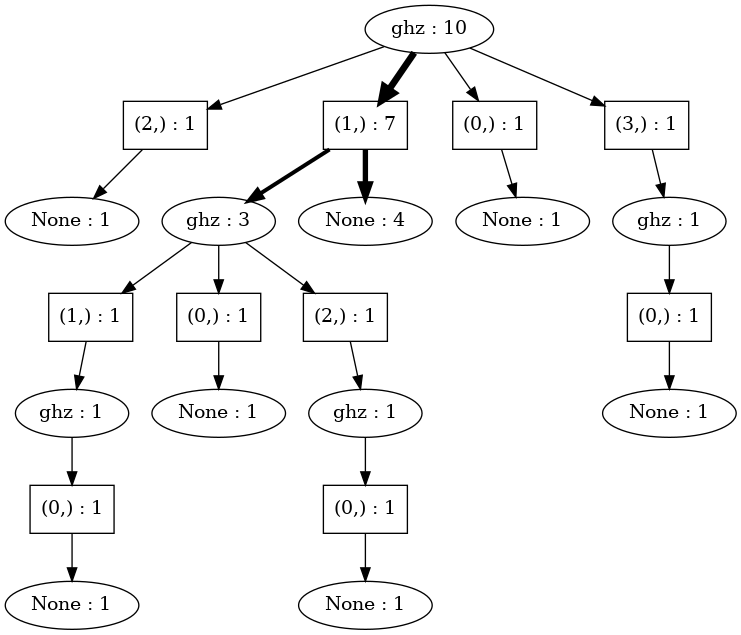

In [ ]:
#| slow

from qsample.examples import ghz3
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.noise import E1
import qsample.callbacks as cb

sample_range = np.logspace(-3,0,5)
err_params = {'q': sample_range}
p_max = {'q': 0.1}

ss_sam = SubsetSamplerERV(protocol=ghz3, simulator=CHP,  p_max=p_max, err_model=E1, err_params=err_params)
ss_sam.run(10, callbacks=[cb.PrintERVPerShot()])
ss_sam.tree.draw()